In [1]:
import sys
sys.path.append("~/git/spinningup")

In [49]:
from spinup.utils.test_policy import load_policy_and_env, run_policy
import gym
env_id = 'gym_space:SpaceshipHover1DContinuous-v0'
env = gym.make(env_id)
# output_dir = "/home/kajetan/git/spinningup/data/ddpg/ddpg_hover_6_neurons"
output_dir = "/home/kajetan/git/spinningup/data/ddpg/ddpg_hover_2x4_50epoch"

/home/kajetan/git/gym-space/.venv/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [50]:
# _, get_action = load_policy_and_env(output_dir)
# run_policy(env, get_action)

In [51]:
import torch
ac = torch.load(f"{output_dir}/pyt_save/model.pt")


In [52]:
import matplotlib.pyplot as plt
def imshow(arr):
    plt.imshow(
    arr,
    origin='lower',
    extent=(-max_abs_velocity, max_abs_velocity, 0, 5),
    aspect='auto',
    )
    plt.colorbar()
    plt.xlabel("velocity")
    plt.ylabel("position")

In [53]:
import numpy as np
max_abs_velocity = 1.2e-2
obs = torch.zeros((100, 6))
obs[:, 1] = torch.linspace(2, 7, 100)
obs[:, 2] = 1.5 * np.pi
def q_vals_from_act(act):
    q_vals = np.empty((100, 100))
    for i, velocity in enumerate(np.linspace(-max_abs_velocity, max_abs_velocity, 100)):
        obs[:, 4] = velocity
        q_vals[:, i] = ac.q.forward(obs, act).detach().numpy()
    return q_vals

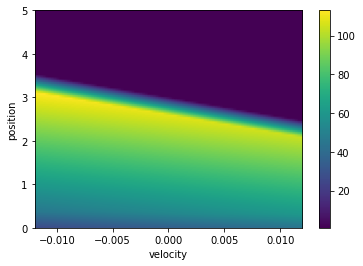

In [54]:
no_thrust_act = torch.zeros(100, 2)
no_thrust_act[:, 0] = -1
q_no_thrust = q_vals_from_act(no_thrust_act)
imshow(q_no_thrust)

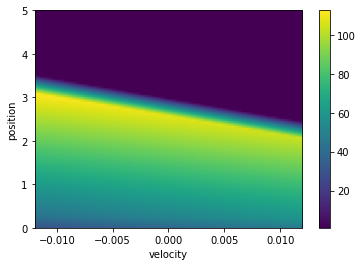

In [55]:
full_thrust_act = torch.zeros(100, 2)
full_thrust_act[:, 0] = 1
q_full_thrust = q_vals_from_act(full_thrust_act)
imshow(q_full_thrust)

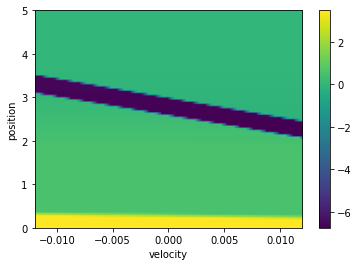

In [56]:
imshow(q_full_thrust - q_no_thrust)

In [39]:
from scipy.optimize import minimize_scalar
from tqdm.notebook import tqdm
def best_actions():
    ret = np.empty((100, 100))
    obs = torch.zeros(6)
    obs[2] = 1.5 * np.pi
    for i, pos in tqdm(enumerate(np.linspace(2, 7, 100))):
        for j, velocity in enumerate(np.linspace(-max_abs_velocity, max_abs_velocity, 100)):
            obs[1] = pos
            obs[4] = velocity
            def q(a):
                return ac.q.forward(obs, torch.tensor([a, 0.0], dtype=torch.float32)).detach().numpy()
            opt_res = minimize_scalar(q, bounds=(-1, 1), method="bounded")
            assert opt_res.success, opt_res.message
            ret[i, j] = opt_res.x
    return (ret + 1) / 2


In [40]:
best_act = best_actions()

0it [00:00, ?it/s]

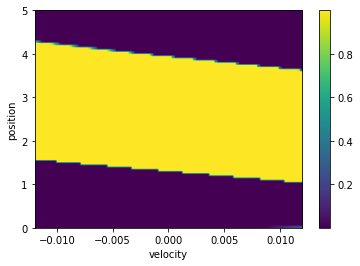

In [41]:
imshow(best_act)

In [57]:
def pi_actions():
    obs = torch.zeros((100, 6))
    obs[:, 1] = torch.linspace(2, 7, 100)
    obs[:, 2] = 1.5 * np.pi
    ret = np.empty((100, 100))
    for i, velocity in enumerate(np.linspace(-max_abs_velocity, max_abs_velocity, 100)):
        obs[:, 4] = velocity
        ret[:, i] = ac.pi.forward(obs).detach().numpy()[:, 0]
    return (ret + 1) / 2

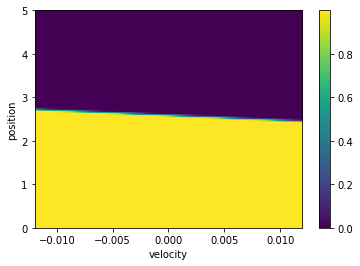

In [58]:
pi_act = pi_actions()
imshow(pi_act)